# Summary of Findings


### Introduction
For the NYPD dataset, I wanted to build a model to try and predict the complainant ethnicity based off of features from the dataset. This dataset contains some interesting features that could be useful to predict complainant ethnicity such as the ethnicity of the police officer and the outcome of the case. This is a classification problem because I am trying to classify the complainant's by their ethnicity. The complainant ethnicity is composed of several categories: 'Black', 'White', 'Asian', 'Refused', 'Hispanic', 'Unknown', 'Other Race', 'American Indian'. Though 'refused' isn't its own category, I thought it'd be interesting keep and try to predict. The evaluation metric I used was the accuracy through the .score() method within the vairous classifiers I used. I thought that the accuracy would be summarize the wellness of my model.

### Baseline Model
The baseline model utilized the KNeighborsClassifier as its classifying model. But before running my data though the model, I id some light feature engineering, mainly to the many nominal features in the dataset. While doing some EDA, some of the columns were integers or floats even though the values within them were nomial. So firstly, I used a function transformer to change all the nominal values to strings. Then, to allow the nominal columns to be used in the classifier, I one hot encoded the nominal columns. I left the numeric data as is. To train and test my baseline model, I did a 70-30 split on the data and included every column except the target variable ('complainant_ethnicity') in my X and only the complainant_ethnicity in my y. I used the train_test_split function to break up my data. The model utilize 27 features as it can be seen below in the code. After training and predicting, I got a score back of 0.65. I feel that this score could be improved with using new engineered features and utilizing other classification models.

### Final Model
For the final model, I firstly added two new engineered features using and self-defined StdScalerByGroup transformer. This transformer normalizes all the values of the column given columns for each subgroup. I utilized this transformer on the mos age at the incident. This would be good for the dataset because the standardized age given the mos ethnicity could add more insight and help with the prediction. In addition, I binarized the age of mos at the incident where the cutoff was 35. Officers above a certain age range may have some bias and will give good info into our model for prediction. I gathered all of the preprocessing transformations in a ColumnTransformer. I then gathered a list of classification models including KNeighbors, DecisionTree, and RandomForest. I wanted to see which classifier gave me the best results so I iterated through the list of models, then for each model I fit and scored the model 10 times and averaged their results. As you can see in the code below, the RandomForestGenerator gave the best score and compared to the KNeighbors, it was significantly better while compared the DecisionTree, the two were somewhat close. After that I grid searched and cros validated 3 different parameters to find what the most ideal arguments would be and used a cv of 3. This told me that the best arguments were max_depth: None, min_samples_leaf: 1, n_estimators: 20. Inputting these arguments into our final model pipeline, and running and scoring, an accuracy of 0.85 was achieved which is definitely a big improvement from our baseline.

### Fairness Evaluation
For the fairness evaluation, I wanted to see whether or not my model predictd fairly in the cases that included white officers vs poc officers. To evaluate my claim I used sensitivity/recall as my parity measure as there seemed to be a roughly equal proportion of white to poc officers and determining how many of the outcomes that were atually positive were true positive is a good measure of fairness of the model. And for my test statistic, I used the absolute difference of the sensitivities because it is a good measure to see how different the two values are. If they are really different from each other, then we will get a large absolute difference and vice versa.The question of "Does the model predict fairly for POC vs Non-POC officers?" leads to the null hypothesis that the model does perform fairly for each group and the sensitivites are the same. On the other hand, the alternative hypothesis is that the senstivies for the two groups are different. To obtain my observed test statistic, I split the dataset into two groups: white and poc officers. Then for each group I made a training and test set, trained individual models, predicted, and obtained recall scores. The resulting absolute difference was 0.0108. But we don't know if this is a lareg difference or not so we need to run a permutation test. After running the permutation test and plotting the p-value on the distribution of simulated absolute differences, using our significance level of 0.05, we can see that the probability that we saw our observed statistic under the null hypothesis was not that low. This tell us that we fail to reject the null hypothesis.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [572]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Binarizer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [481]:
# load in data
complaints = pd.read_csv('CCRB-Complaint-Data_202007271729/allegations_202007271729.csv')
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


### Baseline Model

In [614]:
str_cast_cols = ['unique_mos_id', 'shield_no', 'complaint_id', 'precinct', \
             'month_received', 'year_received', 'month_closed', 'year_closed']
str_cast_pipe = Pipeline([('str_cast', FunctionTransformer(lambda x: x.astype('str')))])

one_hot_cols = ['unique_mos_id', 'month_received', 'year_received', 'month_closed', 'year_closed', \
               'command_at_incident', 'rank_abbrev_now', 'rank_abbrev_incident', 'mos_gender', \
                'mos_ethnicity', 'board_disposition', 'fado_type', 'precinct']
one_hot_pipe = Pipeline([('one_hot', OneHotEncoder(handle_unknown = 'ignore'))])

In [615]:
baseline_preprocess = ColumnTransformer([('str_cast_trans', str_cast_pipe, str_cast_cols), 
                                         ('one_hot_trans', one_hot_pipe, one_hot_cols)])

In [617]:
# build full model here
baseline_pipe = Pipeline([('preprocess', baseline_preprocess), 
                          ('KNeighbors', KNeighborsClassifier())])

In [618]:
X = complaints.drop('complainant_ethnicity',axis = 1)
y = complaints[['complainant_ethnicity']]

In [619]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [623]:
# number of features
len(X_train.columns)

27

In [620]:
# evaluation of baseline
baseline_pipe.fit(X_train, y_train.values.ravel())

baseline_pipe.score(X_test, y_test)

0.6501665873393622

### Final Model

In [304]:
from sklearn.base import BaseEstimator, TransformerMixin


class StdScalerByGroup(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)
        
        # A dictionary of means/standard-deviations for each column, for each group.
        mean_std = df.groupby(df.columns[0])[df.columns[:]].agg([np.mean, np.std])

        self.grps_ = mean_std.to_dict()

        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        

        df = pd.DataFrame(X)

        transformed = df.groupby(df.columns[0])\
            .apply(lambda group:
            group.transform(lambda col: col if col.name == df.columns[0]
            else ((col - self.grps_[(col.name, 'mean')][group.name]) / self.grps_[(col.name, 'std')][group.name])))

        
        return transformed.set_index(transformed.columns[0])

In [492]:
# new preprocessing
str_cast_cols = ['unique_mos_id', 'shield_no', 'complaint_id', 'precinct', \
             'month_received', 'year_received', 'month_closed', 'year_closed']
str_cast_pipe = Pipeline([('str_cast', FunctionTransformer(lambda x: x.astype('str')))])

one_hot_cols = ['unique_mos_id', 'month_received', 'year_received', 'month_closed', 'year_closed', \
               'rank_abbrev_now', 'rank_abbrev_incident', 'mos_gender', \
                'mos_ethnicity', 'board_disposition', 'precinct', 'complainant_gender']
one_hot_pipe = Pipeline([('one_hot', OneHotEncoder(handle_unknown = 'ignore'))])

std_group_cols = ['mos_ethnicity', 'mos_age_incident']
std_group_pipe = Pipeline([('std_group_scale', StdScalerByGroup())])

binarizer_cols = ['mos_age_incident']
binarizer_pipe = Pipeline([('over_35', Binarizer(threshold = 35))])

In [517]:
final_preprocess = ColumnTransformer([('str_cast_trans', str_cast_pipe, str_cast_cols), 
                                      ('one_hot_trans', one_hot_pipe, one_hot_cols), 
                                     ('std_group_trans', std_group_pipe, std_group_cols),
                                     ('binarize_trans', binarizer_pipe, binarizer_cols)
                                     ])

In [513]:
# find the best model

classifiers = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

avg_scores = []

for classifier in classifiers:
    individ_scores = []
    for i in range(10):
        final_pipe = Pipeline([('preprocess', final_preprocess), ('Classifier', classifier)])
        
        X = complaints.drop('complainant_ethnicity',axis = 1)
        y = complaints[['complainant_ethnicity']]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        
        final_pipe.fit(X_train, y_train.values.ravel())
        individ_scores.append(final_pipe.score(X_test, y_test))
    
    avg_scores.append(np.mean(individ_scores))
            

In [514]:
avg_scores

[0.6510352213231794, 0.8358281770585435, 0.8642551166111376]

In [526]:
final_pipe = Pipeline([('preprocess', final_preprocess), ('random_forest', RandomForestClassifier())])

In [530]:
X = complaints.drop('complainant_ethnicity',axis = 1)
y = complaints[['complainant_ethnicity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [560]:
# find the best parameters using Grid Search Cross Validation
parameters = 
    'random_forest__n_estimators': [5,10,15,20],
    'random_forest__max_depth': [2,5,10,15,None], 
    'random_forest__min_samples_leaf':[1,2,5,10,15,20]
}

param_tree = GridSearchCV(final_pipe, parameters, cv = 3)
param_tree.fit(X_train, y_train.values.ravel())
param_tree.best_params_

{'random_forest__max_depth': None,
 'random_forest__min_samples_leaf': 1,
 'random_forest__n_estimators': 20}

In [561]:
final_pipe = Pipeline([('preprocess', final_preprocess),
                       ('random_forest', 
                        RandomForestClassifier(max_depth = None, n_estimators = 20, min_samples_leaf = 1))])

In [562]:
final_pipe.fit(X_train, y_train.values.ravel())
final_pipe.score(X_test, y_test)

0.853998096144693

### Fairness Evaluation

#### Question

Does my model predict fairly for POC vs non-POC officer?

#### Parity Measure

For the parity measure, I used senstivity because as we can see from the cell below, there is roughly equal proportions of white and poc officer and we want to measure how well it correctly identified the results that were actually positive.

In [563]:
np.mean(complaints['mos_ethnicity'] == 'White')

0.5288804797943738

#### Null Hypothesis

The model is fair, the sensitvities for white officers and non-white officers should be roughly the same.

#### Alternative Hypothesis

The model is not fair, the sensitvities for white officers and non-white officers are not the same.

#### Test Statistic

Absolute difference in sensitivities

In [568]:
# Add a col indicating if the officer is white or a poc
complaints['mos_is_white'] = (complaints['mos_ethnicity'] == 'White')

In [597]:
# Observed Test Stat
white_mos_complaints = complaints.loc[complaints['mos_is_white'] == True]
poc_mos_complaints = complaints.loc[complaints['mos_is_white'] == False]

X_white_mos = white_mos_complaints.drop('complainant_ethnicity',axis = 1)
y_white_mos = white_mos_complaints[['complainant_ethnicity']]

X_white_mos_train, X_white_mos_test, y_white_mos_train, y_white_mos_test = train_test_split(X_white_mos, y_white_mos, test_size=0.3)

X_poc_mos = poc_mos_complaints.drop('complainant_ethnicity',axis = 1)
y_poc_mos = poc_mos_complaints[['complainant_ethnicity']]

X_poc_mos_train, X_poc_mos_test, y_poc_mos_train, y_poc_mos_test = train_test_split(X_poc_mos, y_poc_mos, test_size=0.3)

white_mos_pipe = final_pipe.fit(X_white_mos_train, y_white_mos_train.values.ravel())
white_mos_preds = white_mos_pipe.predict(X_white_mos_test)

poc_mos_pipe = final_pipe.fit(X_poc_mos_train, y_poc_mos_train.values.ravel())
poc_mos_preds = poc_mos_pipe.predict(X_poc_mos_test)

white_mos_recall = metrics.recall_score(y_white_mos_test, white_mos_preds, average = 'micro')
poc_mos_recall = metrics.recall_score(y_poc_mos_test, poc_mos_preds, average = 'micro')

obsv_diff = abs(white_mos_recall - poc_mos_recall)
obsv_diff

0.010848075808705726

In [601]:
# permutation test
n_repetitions = 100

differences = []
for _ in range(n_repetitions):
    
    # shuffle the mos_ethnicity
    shuffled_ethnicity = (
        complaints['mos_ethnicity']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        complaints
        .assign(**{'shuffled_mos_ethnicity': shuffled_ethnicity})
    )
    
    shuffled.dropna()
    shuffled['mos_is_white'] = (shuffled['shuffled_mos_ethnicity'] == 'White')
    
    white_mos_complaints = shuffled.loc[shuffled['mos_is_white'] == True]
    poc_mos_complaints = shuffled.loc[shuffled['mos_is_white'] == False]

    X_white_mos = white_mos_complaints.drop('complainant_ethnicity',axis = 1)
    y_white_mos = white_mos_complaints[['complainant_ethnicity']]

    X_white_mos_train, X_white_mos_test, y_white_mos_train, y_white_mos_test = train_test_split(X_white_mos, y_white_mos, test_size=0.3)

    X_poc_mos = poc_mos_complaints.drop('complainant_ethnicity',axis = 1)
    y_poc_mos = poc_mos_complaints[['complainant_ethnicity']]

    X_poc_mos_train, X_poc_mos_test, y_poc_mos_train, y_poc_mos_test = train_test_split(X_poc_mos, y_poc_mos, test_size=0.3)

    white_mos_pipe = final_pipe.fit(X_white_mos_train, y_white_mos_train.values.ravel())
    white_mos_preds = white_mos_pipe.predict(X_white_mos_test)

    poc_mos_pipe = final_pipe.fit(X_poc_mos_train, y_poc_mos_train.values.ravel())
    poc_mos_preds = poc_mos_pipe.predict(X_poc_mos_test)

    white_mos_recall = metrics.recall_score(y_white_mos_test, white_mos_preds, average = 'micro')
    poc_mos_recall = metrics.recall_score(y_poc_mos_test, poc_mos_preds, average = 'micro')

    diff = abs(white_mos_recall - poc_mos_recall)
    differences.append(diff)

In [610]:
p_val = np.mean(differences >= obsv_diff)
p_val

0.45

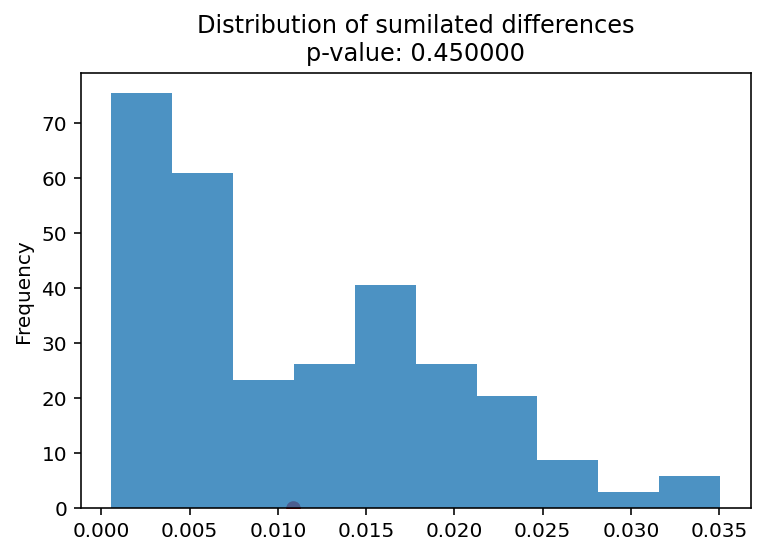

In [611]:
pd.Series(differences).plot(kind='hist', density=True, alpha=0.8, title='Distribution of sumilated differences\np-value: %f' % p_val)
plt.scatter(obsv_diff, 0, color='red', s=40);

As we can see from the distribution and our p-value we fail to reject the null hypothesis.